# Import relevant libraries

In [7]:
#set up
import json
import gzip
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import datetime


In [8]:
plt.style.use('fivethirtyeight')

# Read data

In [9]:
def parse(path):
    g = gzip.open(path, 'rb')
    for i in g:
        yield json.loads(i)
        
def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient = 'index')

In [10]:
ab_r = getDF('All_Beauty.json.gz')
ab_m = getDF('meta_All_Beauty.json.gz')
lb_r = getDF('Luxury_Beauty.json.gz')
lb_m = getDF('meta_Luxury_Beauty.json.gz')

In [38]:
# merge the data

ab_merged = pd.merge(ab_r, ab_m, how='inner', on ='asin')
lb_merged = pd.merge(lb_r, lb_m, how='inner', on ='asin')

In [39]:
ab_merged.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,...,main_cat,description,also_view,also_buy,price,similar_item,details,feature,tech1,date
0,1.0,True,"02 19, 2015",A1V6B6TNIC10QE,0143026860,theodore j bigham,great,One Star,1424304000,NaN,...,All Beauty,[This is the NEW PURPLE BOTTLE that just came ...,[B000LXTNMW],NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.0,True,"12 18, 2014",A2F5GHSXFQ0W6J,0143026860,Mary K. Byke,My husband wanted to reading about the Negro ...,... to reading about the Negro Baseball and th...,1418860800,NaN,...,All Beauty,[This is the NEW PURPLE BOTTLE that just came ...,[B000LXTNMW],NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,True,"08 10, 2014",A1572GUYS7DGSR,0143026860,David G,"This book was very informative, covering all a...",Worth the Read,1407628800,NaN,...,All Beauty,[This is the NEW PURPLE BOTTLE that just came ...,[B000LXTNMW],NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5.0,True,"03 11, 2013",A1PSGLFK1NSVO,0143026860,TamB,I am already a baseball fan and knew a bit abo...,Good Read,1362960000,NaN,...,All Beauty,[This is the NEW PURPLE BOTTLE that just came ...,[B000LXTNMW],NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,True,"12 25, 2011",A6IKXKZMTKGSC,0143026860,shoecanary,This was a good story of the Black leagues. I ...,"More than facts, a good story read!",1324771200,5,...,All Beauty,[This is the NEW PURPLE BOTTLE that just came ...,[B000LXTNMW],NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Cleaning

In [40]:
# data cleaning
to_drop = ['vote','reviewText', 'reviewerName', 'summary','image_x', 'image_y', 'description', 'details']
ab_merged.drop(to_drop, inplace=True, axis=1)
lb_merged.drop(to_drop, inplace=True, axis=1)

In [42]:
## drop NaN

lb_merged_non = lb_merged.dropna(subset=['price'])
ab_merged_non = ab_merged.dropna(subset=['price'])

In [484]:
## Convert unixReviewTime to the datetime
ab_merged_non['DatetimeIndex'] = pd.to_datetime(ab_merged_non['unixReviewTime'],unit='s')
lb_merged_non['DatetimeIndex'] = pd.to_datetime(lb_merged_non['unixReviewTime'],unit='s')

C:\Users\Tunky\Anaconda3\envs\smn635\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Tunky\Anaconda3\envs\smn635\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [485]:
## build a conver_currency function
def conver_currency(value):
    """
    =============================
    Argument: string
    convert currency 
    - remove $
    - convert string to float
    
    Return: float
    =============================
    
    """
    new_value = value.replace(',','').replace('$','')
    return np.float(new_value)

def to_float(x):
    return np.float(x)

In [486]:
## convert string to float
ab_merged_non['price'] = ab_merged_non['price'].apply(conver_currency)
lb_merged_non['price'] = lb_merged_non['price'].apply(conver_currency)

ValueError: could not convert string to float: '12.90 - 169.95'

## extract products that have reviews over 6 months

In [487]:
# Find the lastest date
lb_edate = min(lb_merged_non['DatetimeIndex'])
lb_ldate = max(lb_merged_non['DatetimeIndex'])
lb_threshold = lb_ldate - datetime.timedelta(days=180)
ab_edate = min(ab_merged_non['DatetimeIndex'])
ab_ldate = max(ab_merged_non['DatetimeIndex'])
ab_threshold = ab_ldate - datetime.timedelta(days=180)

In [488]:
# creat start_date and end_date column 
ab_sdate = ab_merged_non.groupby(by=['asin'], as_index=False)['DatetimeIndex'].min()
ab_sdate.rename(columns={'DatetimeIndex': 'start_date'}, inplace=True)
lb_sdate = lb_merged_non.groupby(by=['asin'], as_index=False)['DatetimeIndex'].min()
lb_sdate.rename(columns={'DatetimeIndex': 'start_date'}, inplace=True)

In [489]:
cal_6months = lambda x: (x+ datetime.timedelta(days=180))
ab_sdate['end_date'] = ab_sdate['start_date'].apply(cal_6months)
lb_sdate['end_date'] = lb_sdate['start_date'].apply(cal_6months)

In [490]:
# merge the dataframe 
df_lb = pd.merge(lb_merged_non, lb_sdate, how='inner', on ='asin')
df_ab = pd.merge(ab_merged_non, ab_sdate, how='inner', on ='asin')

In [491]:
# Exclude products whose first score has been posted by less than six months
df_lb = df_lb[df_lb['start_date'] < lb_threshold]
df_ab = df_ab[df_ab['start_date'] < ab_threshold]

In [492]:
# the very first reviews up to six months later
df_lb = df_lb[df_lb['DatetimeIndex'] < df_lb['end_date']]
df_ab = df_ab[df_ab['DatetimeIndex'] < df_ab['end_date']]


In [493]:
df_lb['#Days'] = df_lb['DatetimeIndex'] - df_lb['start_date']
df_lb['#Days'] = df_lb['#Days'].apply(lambda x: x.days)
df_ab['#Days'] = df_ab['DatetimeIndex'] - df_ab['start_date']
df_ab['#Days'] = df_ab['#Days'].apply(lambda x: x.days)

In [494]:
#Max date within 6 months
series_lb = df_lb.groupby(by=['asin'], as_index=False)['DatetimeIndex'].max()
series_lb.rename(columns={'DatetimeIndex': 'last_review'}, inplace=True)
series_ab = df_ab.groupby(by=['asin'], as_index=False)['DatetimeIndex'].max()
series_ab.rename(columns={'DatetimeIndex': 'last_review'}, inplace=True)

df_lb = pd.merge(df_lb, series_lb, how='inner', on ='asin')
df_ab = pd.merge(df_ab, series_ab, how='inner', on ='asin')

# calculate between first review and last reviws
df_lb['review_gap'] = df_lb['last_review'] - df_lb['start_date']
df_lb['review_gap'] = df_lb['review_gap'].apply(lambda x: x.days)
df_ab['review_gap'] = df_ab['last_review'] - df_ab['start_date']
df_ab['review_gap'] = df_ab['review_gap'].apply(lambda x: x.days)

In [497]:
df_lb.head()

,overall,verified,reviewTime,reviewerID,asin,unixReviewTime,style,title,also_buy,rank,...,main_cat,price,brand,feature,DatetimeIndex,start_date,end_date,#Days,last_review,review_gap
0,2.0,True,"06 15, 2010",A1Q6MUU0B2ZDQG,B00004U9V2,1276560000,NaN,Crabtree & Evelyn - Gardener's Ultra-Moisturis...,"[B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...","4,324inBeautyPersonalCare(",...,Luxury Beauty,$30.00,NaN,NaN,2010-06-15,2010-01-07,2010-07-06,159,2010-06-15,159
1,2.0,True,"06 15, 2010",A1Q6MUU0B2ZDQG,B00004U9V2,1276560000,NaN,Crabtree & Evelyn - Gardener's Ultra-Moisturis...,"[B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...","4,324inBeautyPersonalCare(",...,Luxury Beauty,$30.00,NaN,NaN,2010-06-15,2010-01-07,2010-07-06,159,2010-06-15,159
2,5.0,True,"01 7, 2010",A3HO2SQDCZIE9S,B00004U9V2,1262822400,NaN,Crabtree & Evelyn - Gardener's Ultra-Moisturis...,"[B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...","4,324inBeautyPersonalCare(",...,Luxury Beauty,$30.00,NaN,NaN,2010-01-07,2010-01-07,2010-07-06,0,2010-06-15,159
3,5.0,True,"01 7, 2010",A3HO2SQDCZIE9S,B00004U9V2,1262822400,NaN,Crabtree & Evelyn - Gardener's Ultra-Moisturis...,"[B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...","4,324inBeautyPersonalCare(",...,Luxury Beauty,$30.00,NaN,NaN,2010-01-07,2010-01-07,2010-07-06,0,2010-06-15,159
4,4.0,True,"04 22, 2013",A3TXIN5QWZMHCH,B00005A77F,1366588800,NaN,"Crabtree & Evelyn Hand Soap, Gardeners, 10.1 f...",NaN,NaN,...,Luxury Beauty,$15.99,NaN,NaN,2013-04-22,2012-10-31,2013-04-29,173,2013-04-22,173


In [502]:
#dataset for plot 4
df4_lb=pd.DataFrame(df_lb.groupby(by=['asin','review_gap'],as_index=False)['overall'].count())
df4_ab=pd.DataFrame(df_ab.groupby(by=['asin','review_gap'],as_index=False)['overall'].count())

In [503]:
df4_lb['average pace']=df4_lb['review_gap']/df4_lb['overall']
df4_ab['average pace']=df4_ab['review_gap']/df4_ab['overall']

In [504]:
df4_lb

,asin,review_gap,overall,average pace
0,B00004U9V2,159,4,39.750000
1,B00005A77F,173,4,43.250000
2,B00005NDTD,0,2,0.000000
3,B00005V50B,0,2,0.000000
4,B00005V50C,0,2,0.000000
...,...,...,...,...
6747,B01HIQEOLO,174,4,43.500000
6748,B01HIQHQU0,145,5,29.000000
6749,B01HIQIEYC,165,9,18.333333
6750,B01HJ2UY0W,0,1,0.000000


In [506]:
df_lb['#Weeks'] = df_lb['#Days'].apply(lambda x: int(x/7))
df_ab['#Weeks'] = df_ab['#Days'].apply(lambda x: int(x/7))

In [507]:
# set the datetime as indext
df_lb.set_index('DatetimeIndex', inplace=True)
df_ab.set_index('DatetimeIndex', inplace=True)
# Groupby 
df_lb_g=pd.DataFrame(df_lb.groupby(['asin','#Weeks'])['overall'].count())
df_ab_g=pd.DataFrame(df_ab.groupby(['asin','#Weeks'])['overall'].count())

In [508]:
df_lb_4=pd.DataFrame(df_lb.groupby(['asin'])['overall'].count())
df_ab_4=pd.DataFrame(df_ab.groupby(['asin'])['overall'].count())

In [509]:
df_lb_g.reset_index(inplace=True)
df_ab_g.reset_index(inplace=True)

In [510]:
df_ab_g

,asin,#Weeks,overall
0,014789302X,0,1
1,014789302X,8,1
2,014789302X,12,1
3,014789302X,17,1
4,014789302X,18,1
...,...,...,...
23850,B01HJ84SGM,0,1
23851,B01HJ84SGM,2,1
23852,B01HJ84SGM,15,1
23853,B01HJ84SGM,21,1


In [511]:
df_lb_avg = pd.DataFrame(df_lb_g.groupby('#Weeks')['overall'].count())
df_ab_avg = pd.DataFrame(df_ab_g.groupby('#Weeks')['overall'].count())


In [512]:
df_lb_g.head()

,asin,#Weeks,overall
0,B00004U9V2,0,2
1,B00004U9V2,22,2
2,B00005A77F,0,2
3,B00005A77F,24,2
4,B00005NDTD,0,2


In [513]:
a = pd.DataFrame(df_lb_g.groupby('#Weeks')['overall'].aggregate(np.sum))
b = pd.DataFrame(df_ab_g.groupby('#Weeks')['overall'].aggregate(np.sum))

In [514]:
c.reset_index()
d.reset_index()

,#Weeks,overall
0,0,11843
1,1,12551
2,2,13223
3,3,13925
4,4,14594
5,5,15329
6,6,16101
7,7,16851
8,8,17662
9,9,18429


In [515]:
a.loc[:,'avg'] = a['overall'] / df_lb_avg['overall'] 
b.loc[:,'avg'] = b['overall'] / df_ab_avg['overall']

In [516]:
a['overall']=a['overall'].apply(to_float)
b['overall']=b['overall'].apply(to_float)

In [517]:
a.reset_index(inplace=True)
b.reset_index(inplace=True)

In [518]:
a

,#Weeks,overall,avg
0,0,8649.0,1.280954
1,1,1416.0,2.749515
2,2,974.0,1.917323
3,3,871.0,1.621974
4,4,813.0,1.489011
5,5,835.0,1.621359
6,6,913.0,1.769380
7,7,928.0,1.760911
8,8,825.0,1.556604
9,9,850.0,1.660156


In [519]:
a.loc[:,'cumsum']=a['avg'].transform(np.cumsum)
b.loc[:,'cumsum']=b['avg'].transform(np.cumsum)

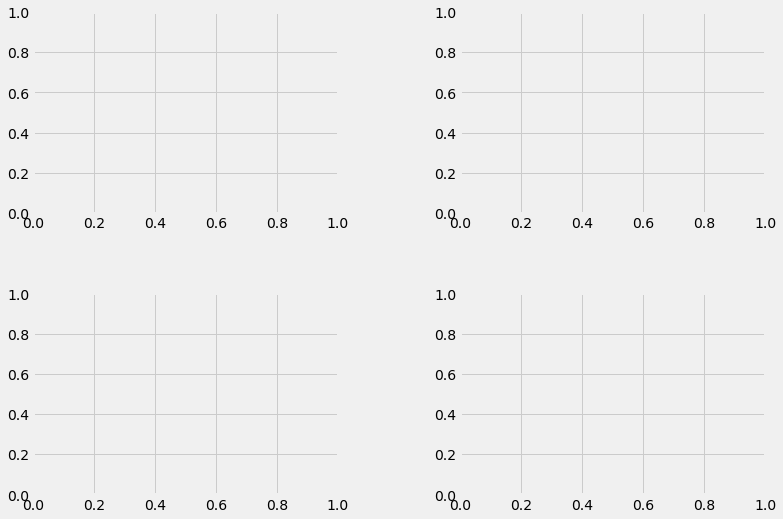

In [520]:
#Figure creation
fig = plt.figure(figsize=(11.69,8.27)) #figure size in inches to fit A4

# parition the figure into 4 subplots with 'gridspec'
gs = gridspec.GridSpec(2, 2, # we want 2 rows, 2 cols
                       figure=fig, # this gs applies to figure
                       hspace=0.4, wspace=0.4, # separation between plots
                       width_ratios=[1, 1], # ration between the first and second column
                       height_ratios=[1, 1]) # ration between the first ans second row

# add plots
ax0 = fig.add_subplot(gs[0, 0]) # this will occupy the first row-first colum
ax1 = fig.add_subplot(gs[0, 1]) # and so on and so forth...
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

In [521]:
#Plot 1
ax0.plot('#Weeks','overall',data=df_lb_g,
         color='red',
         alpha=0.5,
         linewidth=0.2)
ax0.plot('#Weeks','overall',data=df_ab_g,
         color='green',
         alpha=0.5,
         linewidth=0.2)

ax0.plot('#Weeks','avg',data=a,
         color='orange',
         alpha=1,
         marker='o',
         linewidth=1)
ax0.plot('#Weeks','avg',data=b,
         color='blue',
         alpha=1,
         marker='^',
         linewidth=1)


In [522]:
# Plot2
ax1.plot('cumsum', data=a,
         color='blue',
         alpha=1,
         marker='^',
         linewidth=1)
ax1.plot('cumsum', data=b,
         color='orange',
         alpha=1,
         marker='o',
         linewidth=1)

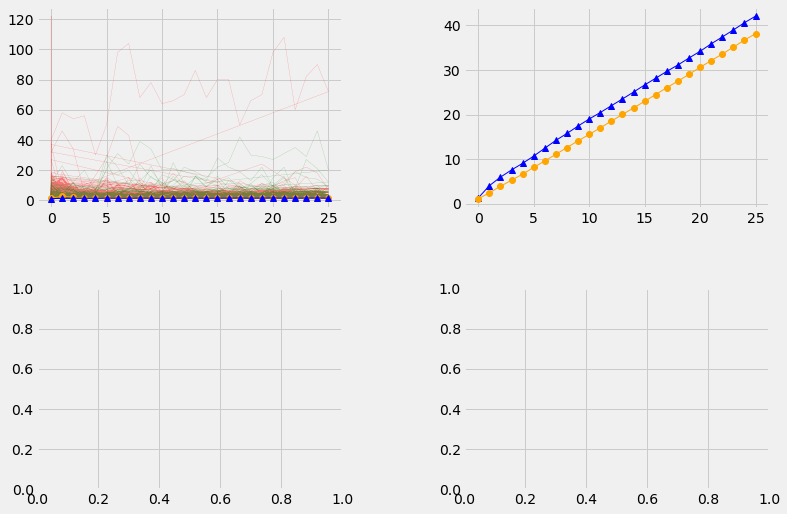

In [523]:
fig

In [525]:
#Plot 4 - Association between count of ratings and average pacing between reviews
#Possibly change to log log plot with y axis being probability and x axis being average pacing
ax3.plot('average pace','overall',data=df4_lb,
         color='green',
         alpha=0.5,
         linewidth=0.2)
ax3.plot('average pace','overall',data=df4_ab,
         color='green',
         alpha=0.5,
         linewidth=0.2)

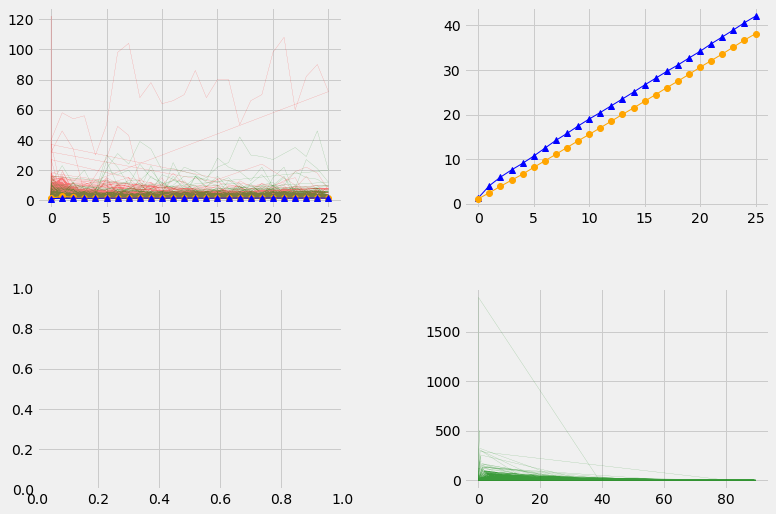

In [526]:
fig